# Self-Driving Car Engineer Nanodegree


## Project: **Behavior Cloning** 
***
In this project we will be workin on creating a deep neural network based on the manual driving data from simulator and train it to drive the car autonomously in the simulator.

Steering angles are predicted from the image data from dashboard camera.

---


## Import Packages

In [13]:
import os
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split


correction = 0.1
#correction array for center, left and right images accessed in the loop below
cr_ar = np.array([0,correction,-correction])

epochs = 3

In [2]:
#Load data, each data folder has different types of data. E.g., data- driving stclockwise, 
#data -2 driving anti clockwise, data - 4 recovery paths etc etc. 
print('load samples')
samples = []
for i in range(1,9):
    with open('./data{}/driving_log.csv'.format(i)) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
print('loaded')



load samples
loaded


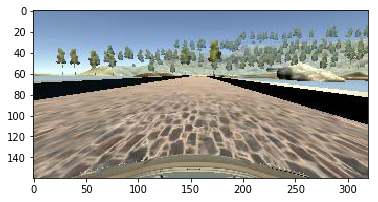

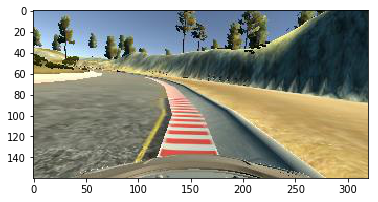

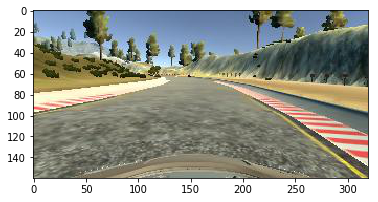

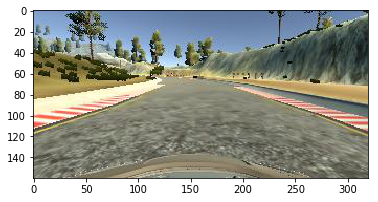

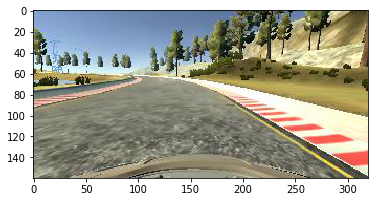

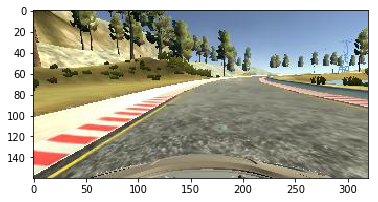

In [24]:
#Plot images for visualization in report
#center image

def process(filename):
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)


#center 
print('center')
process('./data_i/c1.jpg')

print('Recovery path images')
#recovery 1
process('./data_i/r1.jpg')
#recovery 2
process('./data_i/r2.jpg')
#recovery 3
process('./data_i/r3.jpg')

#Normal 1
process('./data_i/n1.jpg')

#Flipped 1
img = mpimg.imread('./data_i/n1.jpg')
plt.figure()
plt.imshow(np.fliplr(img))
plt.show()
#print(img)

## Nvidia Model


Epoch 1/3
88146/88146 [==============================] - 463s - loss: 0.0611 - val_loss: 0.0586
Epoch 2/3
88146/88146 [==============================] - 458s - loss: 0.0572 - val_loss: 0.0483
Epoch 3/3
88146/88146 [==============================] - 457s - loss: 0.0565 - val_loss: 0.0554
dict_keys(['val_loss', 'loss'])


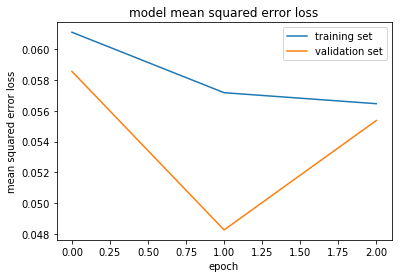

In [4]:
#split the data into two portions for training and validation
(train_samples, validation_samples) = train_test_split(samples,test_size=0.2)

#This function helps parallelise reading and pre processing large amounts data and training the model thus
#reducing the memory constraints and speeding up process also.
def generator(samples, batch_size=512): #old was 32
    num_samples = len(samples)

    # Loop forever so the generator never terminates

    while 1:
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):

            batch_samples = samples[offset:offset + batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):  # i = 0 - center img, 1- left img and 2- right img

                    # having multiple folders for different data sets # folder path + img + file path

                    current_path = './' + batch_sample[i].split('/'
                            )[-3] + '/IMG/' + batch_sample[i].split('/'
                            )[-1]
                    image = cv2.imread(current_path)
                    angle = float(batch_sample[3])
                    images.append(image)
                    angles.append(angle + cr_ar[i])
                    images.append(np.fliplr(image))
                    angles.append(-(angle + cr_ar[i]))

            # trim image to only see section with road

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# Nvidia Architecture as proposed in their end to end driving model
model = Sequential()
model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(160, 320, 3),
          output_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))
model.add(Convolution2D(24, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(36, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(48, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(120))
model.add(Dropout(0.3))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples) * 6,
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    nb_epoch=epochs,
    verbose=1,
    )

#Keys contained in the history object
print(history_object.history.keys())

#Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_n_1.h5')



In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 86, 316, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 43, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________